# [Deep Learning](https://github.com/M-Sc-AUT/M.Sc-Computer-Architecture/tree/main/Deep%20Learning) - Spring 2024
#### [Reza Adinepour](https://github.com/rezaAdinepour)
#### Stu.ID: 402131055

## Question 1:
In this question we train a linearly separable data with multi layer perceptron

### import libraries

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns

### check GPU availability

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### create data and split this
* training set: 80%
* testing set: 20%

In [27]:
x, y = datasets.make_blobs(n_samples=200, centers=[(-1, -1), (1, 1)], cluster_std=0.5)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# convert to the torch tensor
x_train = torch.tensor(x_train, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.long).to(device)

x_test = torch.tensor(x_test, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.long).to(device)

print("X training set size: ", x_train.size())
print("X testing set size: ", x_test.size())

X training set size:  torch.Size([160, 2])
X testing set size:  torch.Size([40, 2])


### plot data

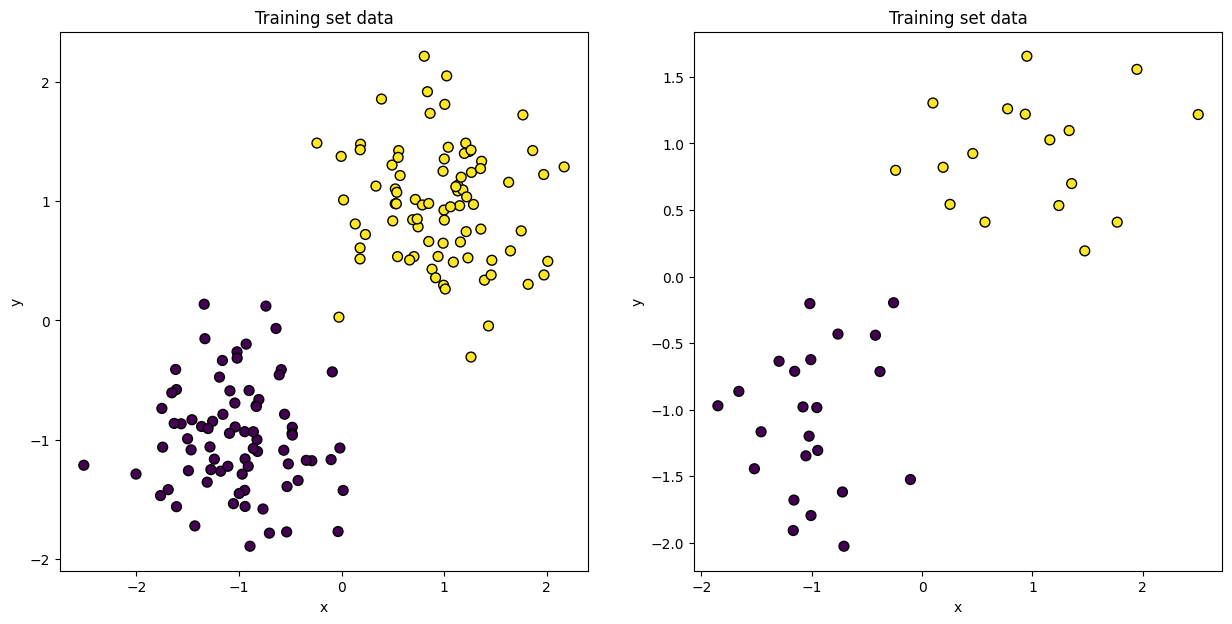

In [28]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.scatter(x_train[:, 0].cpu().numpy(), x_train[:, 1].cpu().numpy(), c=y_train.cpu().numpy(), edgecolors='k', marker='o', s=50)
plt.title("Training set data")
plt.xlabel('x')
plt.ylabel('y')

plt.subplot(1, 2, 2)
plt.scatter(x_test[:, 0].cpu().numpy(), x_test[:, 1].cpu().numpy(), c=y_test.cpu().numpy(), edgecolors='k', marker='o', s=50)
plt.title("Training set data")
plt.xlabel('x')
plt.ylabel('y')

plt.show()

### define MLP class with this structure:
* 3 layer neurons (input + hidden layer + output)
* softmax in output layer
* activation function in each layer: RelU

In [29]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=2, device='cpu'):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.device = torch.device(device)
        self.to(self.device)

    def forward(self, x):
        x = x.to(self.device)
        x = F.relu(self.layer1(x))
        x = self.layer2(x)
        return F.softmax(x, dim=1)

### set network parameters
* input layer neurons: 2
* hidden layer neurons: 2
* output layer neurons: 2
* optimizer: Adam
* loss function: binary cross-entropy
* number of epochs: 200
* learning rate: 0.01

In [30]:
model = MLP(input_size=2, hidden_size=2, output_size=2, device=device)

criterion = torch.nn.BCELoss() # set binary cross entropy for loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # set adam optimizer

epochs = 200 # number of epochs

print("Network parameter:\n ", model)

Network parameter:
  MLP(
  (layer1): Linear(in_features=2, out_features=2, bias=True)
  (layer2): Linear(in_features=2, out_features=2, bias=True)
)


### create one hot label
because in the output we have 2 class

In [31]:
y_train_onehot = F.one_hot(y_train)
y_test_onehot = F.one_hot(y_test)

print("y_train_onehot: ", y_train_onehot.size())
print("y_test_onehot: ", y_test_onehot.size())

print("original labels: ", y_test)
print("onehot encoding labels: ")
print(y_test_onehot)

y_train_onehot:  torch.Size([160, 2])
y_test_onehot:  torch.Size([40, 2])
original labels:  tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
onehot encoding labels: 
tensor([[0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [0, 1]], device='cuda:0')


### train and evaluation phase

In [32]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []


for epoch in range(epochs):
    model.train()
    # forward pass
    outputs = model(x_train)
    
    # calculate loss
    loss = criterion(outputs, y_train_onehot.float())
    
    # backward pass and optimize loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item()) # store train loss
    
    # calculate training accuracy
    _, train_predicted = torch.max(outputs, 1)
    train_correct = (train_predicted == y_train).sum().item()
    train_accuracy = train_correct / y_train.size(0)

    train_acc.append(train_accuracy) # store train accuracy

    # evaluation phase
    model.eval()
    with torch.no_grad():
        outputs = model(x_test)
        loss = criterion(outputs, y_test_onehot.float())  # use one-hot encoded targets

        test_loss.append(loss.item()) # store test loss 

        # calculate test accuracy
        _, test_predicted = torch.max(outputs, 1)
        test_correct = (test_predicted == y_test).sum().item()
        test_accuracy = test_correct / y_test.size(0)

        test_acc.append(test_accuracy) # store accuracy loss
        
    if( (epoch % 15) == 0 ):
        print ('Epoch [{}/{}] | Train Loss: {:.4f} | Train Accuracy: {:.2f} | Test Loss: {:.4f} | Test Accuracy: {:.2f} '.format(epoch+1, epochs, train_loss[-1], train_acc[-1], test_loss[-1], test_acc[-1]))



Epoch [1/200] | Train Loss: 0.7651 | Train Accuracy: 0.48 | Test Loss: 0.6966 | Test Accuracy: 0.57 
Epoch [16/200] | Train Loss: 0.6571 | Train Accuracy: 0.49 | Test Loss: 0.6135 | Test Accuracy: 0.57 
Epoch [31/200] | Train Loss: 0.4444 | Train Accuracy: 0.98 | Test Loss: 0.4179 | Test Accuracy: 0.97 
Epoch [46/200] | Train Loss: 0.2184 | Train Accuracy: 1.00 | Test Loss: 0.2050 | Test Accuracy: 1.00 
Epoch [61/200] | Train Loss: 0.0953 | Train Accuracy: 1.00 | Test Loss: 0.0927 | Test Accuracy: 1.00 
Epoch [76/200] | Train Loss: 0.0493 | Train Accuracy: 1.00 | Test Loss: 0.0506 | Test Accuracy: 1.00 
Epoch [91/200] | Train Loss: 0.0313 | Train Accuracy: 1.00 | Test Loss: 0.0336 | Test Accuracy: 1.00 
Epoch [106/200] | Train Loss: 0.0229 | Train Accuracy: 1.00 | Test Loss: 0.0253 | Test Accuracy: 1.00 
Epoch [121/200] | Train Loss: 0.0181 | Train Accuracy: 1.00 | Test Loss: 0.0204 | Test Accuracy: 1.00 
Epoch [136/200] | Train Loss: 0.0150 | Train Accuracy: 1.00 | Test Loss: 0.0171 |

### plot results

plot loss and accuracy

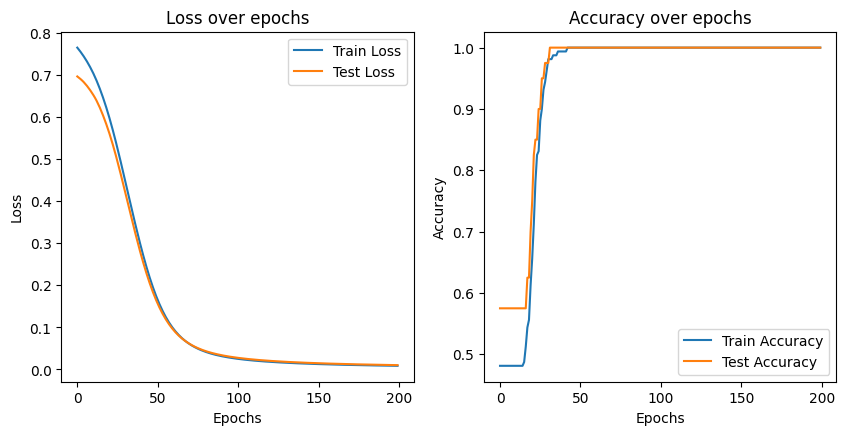

In [33]:
plt.figure(figsize=(10, 10))

# loss
plt.subplot(2, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy
plt.subplot(2, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plot confusion matrix

Text(518.4494949494949, 0.5, 'True class')

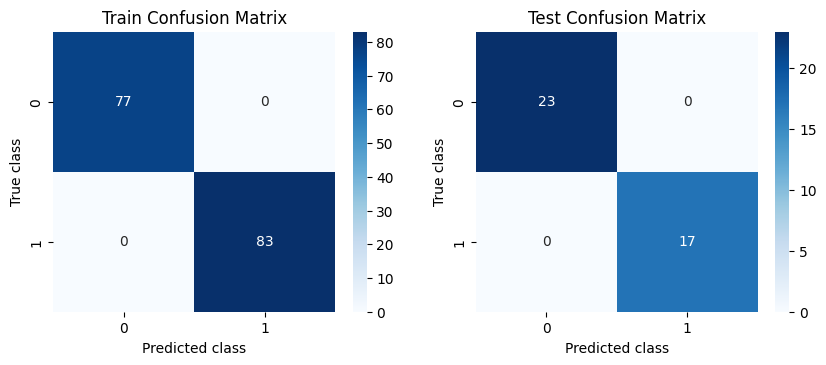

In [34]:
# calculate confusion matrices
train_cm = confusion_matrix(y_train.cpu().numpy(), train_predicted.cpu().numpy())
test_cm = confusion_matrix(y_test.cpu().numpy(), test_predicted.cpu().numpy())

plt.figure(figsize=(10, 8))
# plot train confusion matrix
plt.subplot(2, 2, 3)
sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Train Confusion Matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')

# plot test confusion matrix
plt.subplot(2, 2, 4)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Test Confusion Matrix')
plt.xlabel('Predicted class')
plt.ylabel('True class')

plot the decision boundary

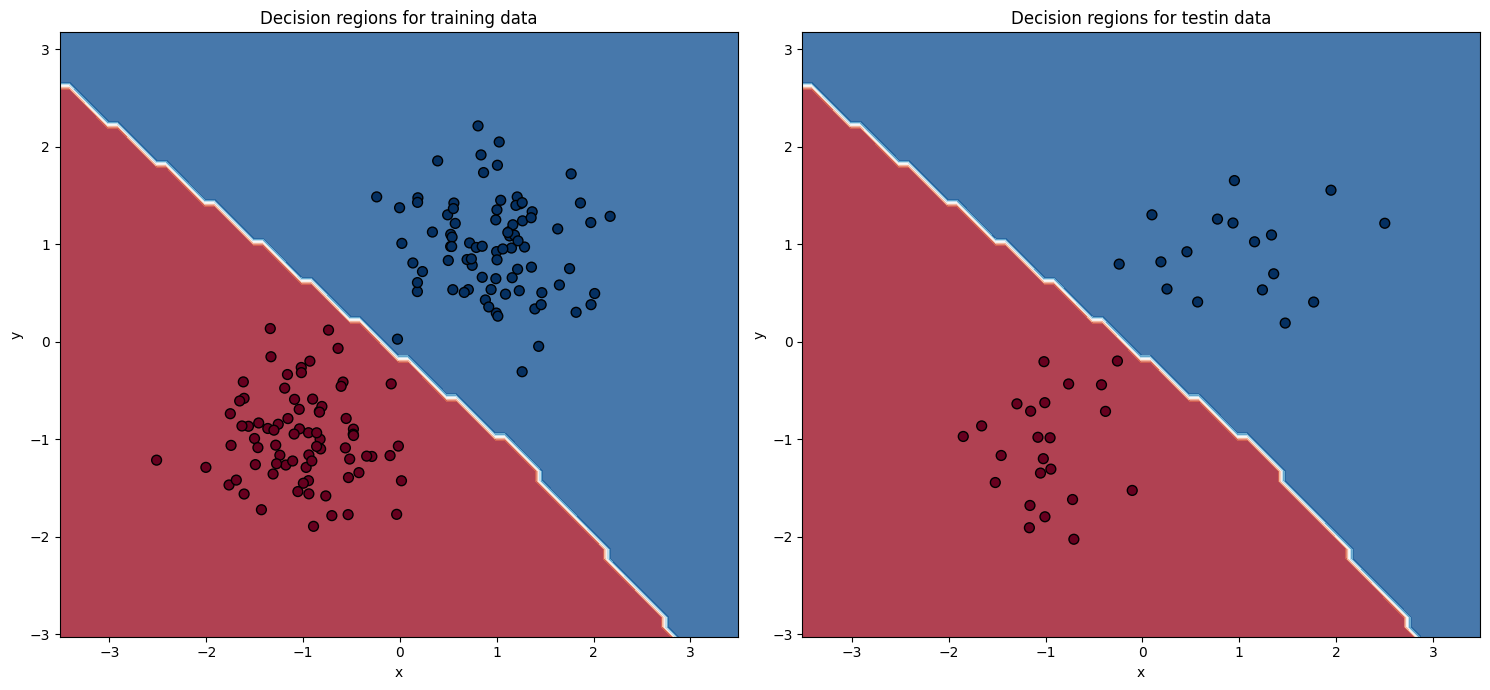

In [35]:
# create a grid of points for coloring
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min.item(), x_max.item(), 0.1),
                     np.arange(y_min.item(), y_max.item(), 0.1))

model.eval()
with torch.no_grad():
    Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float).to(device))
    _, Z = torch.max(Z, 1)
    Z = Z.reshape(xx.shape)

# plot decision regions
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z.cpu().numpy(), alpha=0.8, cmap='RdBu')
plt.scatter(x_train[:, 0].cpu().numpy(), x_train[:, 1].cpu().numpy(), c=y_train.cpu().numpy(), cmap='RdBu', edgecolors='k', marker='o', s=50)
plt.title('Decision regions for training data')
plt.xlabel('x')
plt.ylabel('y')


plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z.cpu().numpy(), alpha=0.8, cmap='RdBu')
plt.scatter(x_test[:, 0].cpu().numpy(), x_test[:, 1].cpu().numpy(), c=y_test.cpu().numpy(), cmap='RdBu', edgecolors='k', marker='o', s=50)
plt.title('Decision regions for testin data')
plt.xlabel('x')
plt.ylabel('y')

plt.tight_layout()
plt.show()